In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import lasio as la
import seaborn as sns
import bruges as br

%matplotlib inline

# Define a default font for the figures
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.size'] = 12

# Extract well log data

In [2]:
#love1 = lasio.read('LOEVE-1_LK.las')
#love1.to_csv('LOEVE-1.csv')
love1 = pd.read_csv('LOEVE-1.csv') # Load into panda Data Frame
love1_units = love1.iloc[0] # Store the units
love1.drop([0],inplace=True) # Remove row of units from the Data Frame
love1 = love1[['DEPTH','GR','PHIT','VSHALE','SW','DT','DTSH6','RHOZ']] # Extract relevant logs
love1 = love1.astype(float) # Convert data type to float number
love1[['DT','DTSH6']] = love1[['DT','DTSH6']].apply(lambda x: x * 3.28084) # us/ft --> us/m

rhoLog_strt = love1[love1['RHOZ']!=4628.8]['DEPTH'].iloc[0] # Density log measurements start

# Smoothing and despiking the logs

In [3]:
def rolling_window(a, window):
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        rolled = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
        
        return rolled
window = 13 # the length of filter is 13 samples or ~ 2 metres

# Smooth density
rho_sm = np.median(rolling_window(love1['RHOZ'],window), -1) # Smooths the logs using a median filter
love1['RHOZ_sm'] = np.pad(rho_sm, np.int(window/2), mode='edge') # "Pads" the log together such that we get original log size

# Smooth P-sonic
dt_sm = np.median(rolling_window(love1['DT'],window), -1) # Smooths the logs using a median filter
love1['DT_sm'] = np.pad(dt_sm, np.int(window/2), mode='edge') # "Pads" the log together such that we get original log size

# Smoothh S-sonic
dts_sm = np.median(rolling_window(love1['DTSH6'],window), -1) # Smooths the logs using a median filter
love1['DTS_sm'] = np.pad(dts_sm, np.int(window/2), mode='edge') # "Pads" the log together such that we get original log size

# Despike function
def despike(curve, curve_sm, max_clip): 
    spikes = np.where(curve - curve_sm > max_clip)[0]
    spukes = np.where(curve_sm - curve > max_clip)[0]
    out = np.copy(curve)
    out[spikes] = curve_sm[spikes] + max_clip  # Clip at the max allowed diff
    out[spukes] = curve_sm[spukes] - max_clip  # Clip at the min allowed diff
    return out

love1['RHOZ_edt'] = despike(love1['RHOZ'],love1['RHOZ_sm'],max_clip=100) 
love1['DT_edt'] = despike(love1['DT'],love1['DT_sm'],max_clip=5) 
love1['DTS_edt'] = despike(love1['DTSH6'],love1['DTS_sm'],max_clip=5)

C:\Users\kenb\Python_Anaconda\envs\obspy\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Series.strides is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kenb\Python_Anaconda\envs\obspy\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 1 results
  r = func(a, **kwargs)
C:\Users\kenb\Python_Anaconda\envs\obspy\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 6777 results
  r = func(a, **kwargs)
C:\Users\kenb\Python_Anaconda\envs\obspy\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 6862 results
  r = func(a, **kwargs)


# Define facies

C:\Users\kenb\Python_Anaconda\envs\obspy\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\kenb\Python_Anaconda\envs\obspy\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kenb\Python_Anaconda\envs\obspy\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stabl

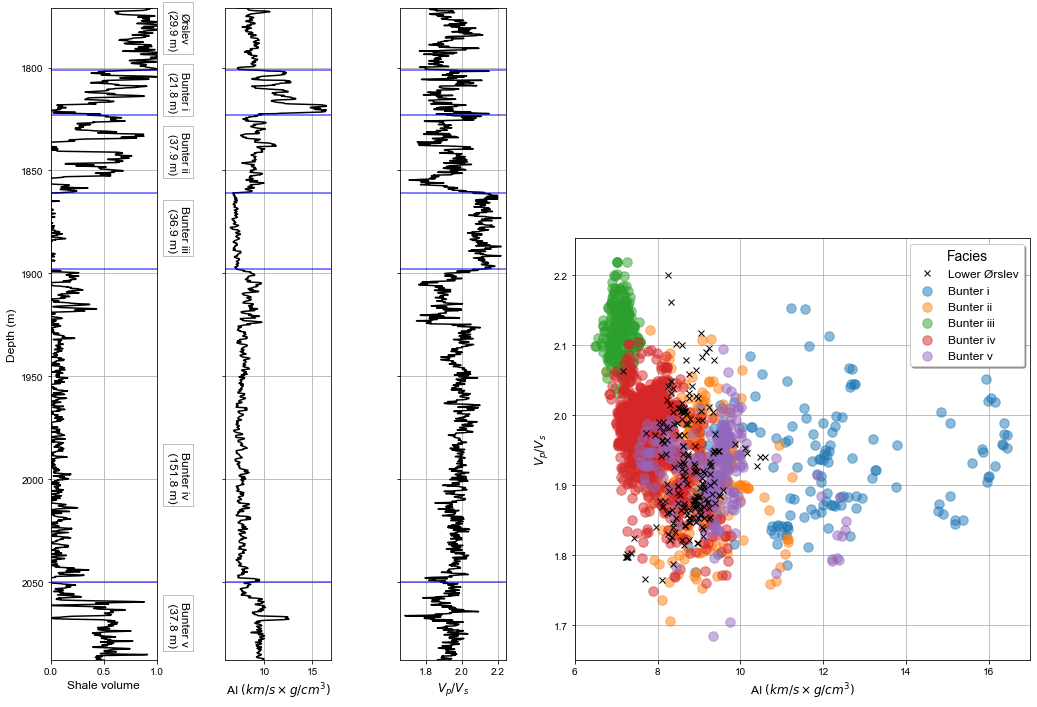

In [4]:
# Get well tops for plot annotation

tops = pd.read_excel('Loeve_Tops.xlsx')
tops.drop([0],inplace=True)
    
# Define elastic logs
love1['Vp'] = (1e3 / love1['DT_edt'])
love1['Vs'] = (1e3 / love1['DTS_edt'])
love1['AI'] = love1['Vp'] * love1['RHOZ_edt']
love1['PS'] = love1['Vp'] / love1['Vs']

# Crop reservoir interval
resSec = love1[(love1['DEPTH'] >= float(tops[tops['Top'] == 'Bunter SST']['Start']-30)) & (love1['DEPTH'] < float(tops[tops['Top'] == 'Bunter SH']['Start']+20))]

# Subdivide reservoir into ("0") Upper shale zone 1, ("1") Upper shale zone 2, ("2") clean reservoir zone, and ("3") shaly reservoir zone
resSec['F'] = np.zeros(len(resSec))
resSec['F_label'] = ["" for x in range(len(resSec))]
intf = [tops['Start'].loc[8],1823, 1861, 1898, 2050] # interfaces
Fstr = 'Lower Ørslev,Bunter i,Bunter ii,Bunter iii,Bunter iv,Bunter v'
Fstr = Fstr.split(',')

resSec['F'].loc[(resSec['DEPTH'] >= intf[0]) & (resSec['DEPTH'] <= intf[1])] = 1
resSec['F'].loc[(resSec['DEPTH'] > intf[1]) & (resSec['DEPTH'] <= intf[2])] = 2
resSec['F'].loc[(resSec['DEPTH'] > intf[2]) & (resSec['DEPTH'] <= intf[3])] = 3
resSec['F'].loc[(resSec['DEPTH'] > intf[3]) & (resSec['DEPTH'] <= intf[4])] = 4
resSec['F'].loc[(resSec['DEPTH'] > intf[4])] = 5

resSec['F_label'].loc[(resSec['DEPTH'] < intf[0])] = Fstr[0]
resSec['F_label'].loc[(resSec['DEPTH'] >= intf[0]) & (resSec['DEPTH'] <= intf[1])] = Fstr[1]
resSec['F_label'].loc[(resSec['DEPTH'] >= intf[1]) & (resSec['DEPTH'] <= intf[2])] = Fstr[2]
resSec['F_label'].loc[(resSec['DEPTH'] >= intf[2]) & (resSec['DEPTH'] <= intf[3])] = Fstr[3]
resSec['F_label'].loc[(resSec['DEPTH'] >= intf[3]) & (resSec['DEPTH'] <= intf[4])] = Fstr[4]
resSec['F_label'].loc[(resSec['DEPTH'] > intf[4])] = Fstr[5]

dz = []
for m in range(0,len(Fstr)):
    dz.append(resSec[resSec['F']==m]['DEPTH'].diff().sum())

fig = plt.figure(figsize=(16,12))
#
gs1 = gridspec.GridSpec(nrows=3, ncols=6, left = 0.05, wspace=0.65)
ax1 = fig.add_subplot(gs1[:, 0])
ax2 = fig.add_subplot(gs1[:, 1])
ax3 = fig.add_subplot(gs1[:, 2])
ax4 = fig.add_subplot(gs1[1:3, 3:6])

# Shale volume
ax1.plot(resSec['VSHALE'],resSec['DEPTH'],'k-')
ax1.axis('tight')
ax1.set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH']))
ax1.invert_yaxis()
ax1.set_xlim(0,1)
ax1.set_xlabel('Shale volume', fontsize = 12)
ax1.set_ylabel('Depth (m)', fontsize = 12)
ax1.grid()

# AI
ax2.plot(resSec['AI'],resSec['DEPTH'],'k-')
ax2.axis('tight')
ax2.set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH']))
ax2.invert_yaxis()
ax2.set_xlabel('AI '+ r'$(km/s \times g/cm^3)$', fontsize = 12)
ax2.set_yticklabels('')
ax2.grid()

# Vp/Vs
ax3.plot(resSec['PS'],resSec['DEPTH'],'k-')
ax3.axis('tight')
ax3.set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH']))
ax3.invert_yaxis()
ax3.set_xlabel(r'$V_p/V_s$', fontsize = 12)
ax3.set_yticklabels('')
ax3.grid()

for n in range(0,len(intf)):
    ax1.axhline(y = intf[n], color = 'b', lw = 2, linestyle = '-',
                   alpha = 0.5)    
    ax2.axhline(y = intf[n], color = 'b', lw = 2, linestyle = '-',
                   alpha = 0.5)
    ax3.axhline(y = intf[n], color = 'b', lw = 2, linestyle = '-',
                   alpha = 0.5)
    
ax1.text(x = ax1.set_xlim()[1]+0.2, y =intf[0]-20, s = 'Ørslev\n ({0} m)'.format(str(round(dz[0],1))),
        fontsize = '11',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0.5),
        weight = 'light',
        rotation=-90)

ax1.text(x = ax1.set_xlim()[1]+0.2, y =intf[0]+10, s = 'Bunter i\n ({0} m)'.format(str(round(dz[1],1))),
        fontsize = '11',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0.5),
        weight = 'light',
        rotation=-90)

ax1.text(x = ax1.set_xlim()[1]+0.2, y =intf[2]-20, s = 'Bunter ii\n ({0} m)'.format(str(round(dz[2],1))),
        fontsize = '11',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0.5),
        weight = 'light',
        rotation=-90)

ax1.text(x = ax1.set_xlim()[1]+0.2, y =intf[3]-20, s = 'Bunter iii\n ({0} m)'.format(str(round(dz[3],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0.5),
        weight = 'light',
        rotation=-90)


ax1.text(x = ax1.set_xlim()[1]+0.2, y =intf[3]+100, s = 'Bunter iv\n ({0} m)'.format(str(round(dz[4],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0.5),
        weight = 'light',
        rotation=-90)

ax1.text(x = ax1.set_xlim()[1]+0.2, y =intf[4]+20, s = 'Bunter v\n ({0} m)'.format(str(round(dz[5],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0.5),
        weight = 'light',
        rotation=-90)

# AI vs Vp/Vs

groups = resSec['F_label'].unique()

for i in range(len(groups)):
    x, y = (resSec[resSec['F_label']==groups[i]]['AI'],resSec[resSec['F_label']==groups[i]]['PS'])
    if (groups[i]=='Lower Ørslev'):
        ax4.plot(resSec[resSec['F_label']==groups[i]]['AI'],resSec[resSec['F_label']==groups[i]]['PS'],'kx',lw=2,label=groups[i])
    else:
        ax4.scatter(x, y, alpha=0.5, s=90, label=groups[i])


ax4.set_xlabel('AI '+ r'$(km/s \times g/cm^3)$', fontsize = 12)
ax4.set_ylabel(r'$V_p/V_s$', fontsize = 12)
ax4.set_xlim(6,17)
ax4.grid()
ax4.set_axisbelow(True)
lg = plt.legend(loc=1,title='Facies',fontsize=12,fancybox=True,shadow=True)
plt.setp(lg.get_title(),fontsize=14)

#plt.savefig('x-plot.png',dpi=400)
plt.show()

# Blocky model input

In [5]:
###########################################################
#       DEFINE MODELING PARAMETERS HERE

#   3-Layer Model Parameters [Layer1, Layer2, Layer 3]

vp_mod = resSec.groupby('F').mean()['Vp']*1e3  # P-wave velocity (m/s)

vs_mod = resSec.groupby('F').mean()['Vs']*1e3  # S-wave velocity (m/s)

rho_mod = resSec.groupby('F').mean()['RHOZ_edt']  # Density

lit_mod = resSec.groupby('F').mean()['VSHALE']  # Shale

phi_mod = resSec.groupby('F').mean()['PHIT']  # Density


thickness = np.round(dz,1)[1:-1] # vertical thickness of layer 2 in metres

#   Angle range for incident rays
theta1_min = 0.0    # best to leave this set to zero
theta1_max = 40.0
theta1_step= 1.0


#   Wavelet Parameters
wvlt_type = 'ricker'  # Valid values: 'ricker' or 'bandpass'
wvlt_length= 0.128 # Wavelet length in seconds
wvlt_phase = 0.0   # Wavelet phase in degrees
wvlt_scalar = 1.0  # Multiplier to scale wavelet amplitude (default = 1.0)
wvlt_cfreq = 35.0  # Ricker wavelet central frequency
f1 = 3.0          # Bandpass wavelet low truncation frequency
f2 = 8.0          # Bandpass wavelet low cut frequency
f3 = 50.0          # Bandpass wavelet high cut frequency
f4 = 65.0          # Bandpass wavelet high truncation frequency


#   Trace Parameters
tmin = 0.0
tmax = 0.5
dt = 0.0001 # changing this from 0.0001 can affect the display quality


#   Plotting Display Parameters
min_plot_time = 0.02
max_plot_time = 0.25
excursion = 2

# Function definitions

In [25]:
def plot_vawig(axhdl, data, t, excursion):

    import numpy as np
    import matplotlib.pyplot as plt

    [ntrc, nsamp] = data.shape
    

    
    
    t = np.hstack([0, t, t.max()])
    
    for i in range(0, ntrc):
        tbuf = excursion * data[i,:] / np.max(np.abs(data)) + i
        
        tbuf = np.hstack([i, tbuf, i])
            
        axhdl.plot(tbuf, t, color='black', linewidth=0.5)
        plt.fill_betweenx(t, tbuf, i, where=tbuf>i, facecolor='k', linewidth=0, alpha=0.5)
        #plt.fill_betweenx(t, tbuf, i, where=tbuf<i, facecolor=[0.6,0.6,1.0], linewidth=0)
    
    axhdl.set_xlim((-excursion, ntrc+excursion))
    axhdl.xaxis.tick_top()
    axhdl.xaxis.set_label_position('top')
    axhdl.invert_yaxis()
    
  
    
def ricker(cfreq, phase, dt, wvlt_length):
    '''
    Calculate a zero-phase ricker wavelet
    
    Usage:
    ------
    t, wvlt = wvlt_ricker(cfreq, dt, wvlt_length)
    
    cfreq: central frequency of wavelet in Hz
    phase: wavelet phase in degrees
    dt: sample rate in seconds
    wvlt_length: length of wavelet in seconds
    '''
    
    import numpy as np
    import scipy.signal as signal
    
    nsamp = int(wvlt_length/dt + 1)
    t_max = wvlt_length*0.5
    t_min = -t_max
    
    t = np.arange(t_min, t_max, dt)
    
    t = np.linspace(-wvlt_length/2, (wvlt_length-dt)/2, wvlt_length/dt)
    wvlt = (1.0 - 2.0*(np.pi**2)*(cfreq**2)*(t**2)) * np.exp(-(np.pi**2)*(cfreq**2)*(t**2))
    
    if phase != 0:
        phase = phase*np.pi/180.0
        wvlth = signal.hilbert(wvlt)
        wvlth = np.imag(wvlth)
        wvlt = np.cos(phase)*wvlt - np.sin(phase)*wvlth
    
    return t, wvlt



def wvlt_bpass(f1, f2, f3, f4, phase, dt, wvlt_length):
    '''
    Calculate a trapezoidal bandpass wavelet
    
    Usage:
    ------
    t, wvlt = wvlt_ricker(f1, f2, f3, f4, phase, dt, wvlt_length)
    
    f1: Low truncation frequency of wavelet in Hz
    f2: Low cut frequency of wavelet in Hz
    f3: High cut frequency of wavelet in Hz
    f4: High truncation frequency of wavelet in Hz
    phase: wavelet phase in degrees
    dt: sample rate in seconds
    wvlt_length: length of wavelet in seconds
    '''
    
    from numpy.fft import fft, ifft, fftfreq, fftshift, ifftshift
    
    nsamp = int(wvlt_length/dt + 1)
    
    
    freq = fftfreq(nsamp, dt)
    freq = fftshift(freq)
    aspec = freq*0.0
    pspec = freq*0.0
    
    # Calculate slope and y-int for low frequency ramp
    M1 = 1/(f2-f1)
    b1 = -M1*f1
    
    # Calculate slop and y-int for high frequency ramp
    M2 = -1/(f4-f3)
    b2 = -M2*f4
    
    # Build initial frequency and filter arrays
    freq = fftfreq(nsamp, dt)
    freq = fftshift(freq)
    filt = np.zeros(nsamp)
    
    # Build LF ramp
    idx = np.nonzero((np.abs(freq)>=f1) & (np.abs(freq)<f2))
    filt[idx] = M1*np.abs(freq)[idx]+b1
    
    # Build central filter flat
    idx = np.nonzero((np.abs(freq)>=f2) & (np.abs(freq)<=f3))
    filt[idx] = 1.0
    
    # Build HF ramp
    idx = np.nonzero((np.abs(freq)>f3) & (np.abs(freq)<=f4))
    filt[idx] = M2*np.abs(freq)[idx]+b2
    
    # Unshift the frequencies and convert filter to fourier coefficients
    filt2 = ifftshift(filt)
    Af = filt2*np.exp(np.zeros(filt2.shape)*1j)
    
    # Convert filter to time-domain wavelet
    wvlt = fftshift(ifft(Af))
    wvlt = np.real(wvlt)
    wvlt = wvlt/np.max(np.abs(wvlt)) # normalize wavelet by peak amplitude

    # Generate array of wavelet times
    t = np.linspace(-wvlt_length*0.5, wvlt_length*0.5, nsamp)
    
    
    # Apply phase rotation if desired
    if phase != 0:
        phase = phase*np.pi/180.0
        wvlth = signal.hilbert(wvlt)
        wvlth = np.imag(wvlth)
        wvlt = np.cos(phase)*wvlt - np.sin(phase)*wvlth
    
    return t, wvlt
    
    

def calc_times(z_int, vp_mod):
    '''
    Calculate two-way travel time through a layered model
    
    Usage:
    -----
    t_int = calc_times(z_int, vp_mod)
    
    '''
    
    nlayers = len(vp_mod)
    nint = nlayers - 1

    t_int = []
    for i in range(0, nint):
        if i == 0:
            tbuf = z_int[i]/vp_mod[i]
            t_int.append(tbuf)
        else:
            zdiff = z_int[i]-z_int[i-1]
            zdiff = zdiff*2.0   # multiply by 2 for two-way traveltimes
            tbuf = zdiff/vp_mod[i] + t_int[i-1]
            tbuf = tbuf
            t_int.append(tbuf)
    
    return t_int

In [26]:
def digitize_model(rc_int, t_int, t):
    '''
    Sample a simple layered reflectivity model
    
    Usage:
    ------
    rc = digitize_model(rc, t_int, t)
    
    rc = reflection coefficients corresponding to interface times
    t_int = interface times
    t = regularly sampled time series defining model sampling
    '''
    
    import numpy as np
    
    nlayers = len(rc_int)
    nint = nlayers - 1
    nsamp = len(t)
    
    rc = list(np.zeros(nsamp,dtype='float'))
    lyr = 0
    
    for i in range(0, nsamp):

        if t[i] >= t_int[lyr]:
            rc[i] = rc_int[lyr]
            lyr = lyr + 1    

        if lyr > nint:
            break
            
    return rc
    

def rc_zoep(vp1, vs1, rho1, vp2, vs2, rho2, theta1):
    '''
    Reflection & Transmission coefficients calculated using full Zoeppritz
    equations.
    
    Usage:
    ------
    R = rc_zoep(vp1, vs1, rho1, vp2, vs2, rho2, theta1)
    
    Reference:
    ----------
    The Rock Physics Handbook, Dvorkin et al.
    '''
    
    import math
    
    # Cast inputs to floats
    vp1  = float(vp1)
    vp2  = float(vp2)
    vs1  = float(vs1)
    vs2  = float(vs2)
    rho1 = float(rho1)
    rho2 = float(rho2)
    theta1 = float(theta1)
    
    # Calculate reflection & transmission angles
    theta1 = math.radians(theta1)   # Convert theta1 to radians
    p      = ray_param(vp1, math.degrees(theta1)) # Ray parameter
    theta2 = math.asin(p*vp2);      # Transmission angle of P-wave
    phi1   = math.asin(p*vs1);      # Reflection angle of converted S-wave
    phi2   = math.asin(p*vs2);      # Transmission angle of converted S-wave
    
    # Matrix form of Zoeppritz Equations... M & N are two of the matricies
    M = np.array([ \
        [-math.sin(theta1), -math.cos(phi1), math.sin(theta2), math.cos(phi2)],\
        [math.cos(theta1), -math.sin(phi1), math.cos(theta2), -math.sin(phi2)],\
        [2*rho1*vs1*math.sin(phi1)*math.cos(theta1), rho1*vs1*(1-2*math.sin(phi1)**2),\
            2*rho2*vs2*math.sin(phi2)*math.cos(theta2), rho2*vs2*(1-2*math.sin(phi2)**2)],\
        [-rho1*vp1*(1-2*math.sin(phi1)**2), rho1*vs1*math.sin(2*phi1), \
            rho2*vp2*(1-2*math.sin(phi2)**2), -rho2*vs2*math.sin(2*phi2)]
        ], dtype='float')
    
    N = np.array([ \
        [math.sin(theta1), math.cos(phi1), -math.sin(theta2), -math.cos(phi2)],\
        [math.cos(theta1), -math.sin(phi1), math.cos(theta2), -math.sin(phi2)],\
        [2*rho1*vs1*math.sin(phi1)*math.cos(theta1), rho1*vs1*(1-2*math.sin(phi1)**2),\
            2*rho2*vs2*math.sin(phi2)*math.cos(theta2), rho2*vs2*(1-2*math.sin(phi2)**2)],\
        [rho1*vp1*(1-2*math.sin(phi1)**2), -rho1*vs1*math.sin(2*phi1),\
            -rho2*vp2*(1-2*math.sin(phi2)**2), rho2*vs2*math.sin(2*phi2)]\
        ], dtype='float')
    
    # This is the important step, calculating coefficients for all modes and rays
    R = np.dot(np.linalg.inv(M), N);
    
    return R


def ray_param(v, theta):
    '''
    Calculates the ray parameter p
    
    Usage:
    ------
        p = ray_param(v, theta)
    
    Inputs:
    -------
            v = interval velocity
        theta = incidence angle of ray (degrees)
    
    Output:
    -------
        p = ray parameter (i.e. sin(theta)/v )
    '''
    
    import math
    
    # Cast inputs to floats
    theta = float(theta)
    v = float(v)
    
    p = math.sin(math.radians(theta))/v # ray parameter calculation
    
    return p

# Computations

In [27]:
#   Some handy constants
nlayers = len(vp_mod)
nint = nlayers - 1
nangles = int( (theta1_max-theta1_min)/theta1_step + 1)


#   Generate wavelet
if wvlt_type == 'ricker':
    wvlt_t, wvlt_amp = ricker(wvlt_cfreq, wvlt_phase, dt, wvlt_length)
    
elif wvlt_type == 'bandpass':
    wvlt_t, wvlt_amp = wvlt_bpass(f1, f2, f3, f4, wvlt_phase, dt, wvlt_length)

#   Apply amplitude scale factor to wavelet (to match seismic amplitude values)
wvlt_amp = wvlt_scalar * wvlt_amp

#   Calculate reflectivities from model parameters
rc_zoep_pp = []
theta1 = []
for i in range(0, nangles):
    theta1_buf = i*theta1_step + theta1_min
    rc_buf1 = rc_zoep(vp_mod[0], vs_mod[0], rho_mod[0], vp_mod[1], vs_mod[1], rho_mod[1], theta1_buf)
    rc_buf2 = rc_zoep(vp_mod[1], vs_mod[1], rho_mod[1], vp_mod[2], vs_mod[2], rho_mod[2], theta1_buf)
    rc_buf3 = rc_zoep(vp_mod[2], vs_mod[2], rho_mod[2], vp_mod[3], vs_mod[3], rho_mod[3], theta1_buf)
    rc_buf4 = rc_zoep(vp_mod[3], vs_mod[3], rho_mod[3], vp_mod[4], vs_mod[4], rho_mod[4], theta1_buf)
    rc_buf5 = rc_zoep(vp_mod[4], vs_mod[4], rho_mod[4], vp_mod[5], vs_mod[5], rho_mod[5], theta1_buf)
    
    theta1.append(theta1_buf)
    rc_zoep_pp.append([rc_buf1[0,0], rc_buf2[0,0], rc_buf3[0,0], rc_buf4[0,0], rc_buf5[0,0]])


#   Define time sample vector for output model & traces
nsamp = int((tmax-tmin)/dt) + 1
t = []
for i in range(0,nsamp):
    t.append(i*dt)


syn_zoep_pp = []
lyr_times = []
#print("\n\nStarting synthetic calcuations...\n")
for angle in range(0, nangles):
    
    dz_app = thickness
    
    #   To calculate apparent thickness of layer 2 based on incidence angle
    #   uncomment the following three rows (e.g. ray-synthetics)
    #p = ray_param(vp_mod[0], angle)
    #angle2 = math.degrees(math.asin(p*vp_mod[1]))
    #dz_app = thickness/math.cos(math.radians(angle2))
    
    #   Calculate interface depths
    z_int = [200, 0, 0, 0, 0]
    for i in range(1,nint):
        z_int[i] = z_int[i-1]+dz_app[i-1]
    
    #   Calculate interface times
    t_int = calc_times(z_int, vp_mod)
    lyr_times.append(t_int)
    
    #   Digitize 3-layer model
    rc = digitize_model(rc_zoep_pp[angle], t_int, t)

    #   Convolve wavelet with reflectivities
    syn_buf = np.convolve(rc, wvlt_amp, mode='same')
    #syn_buf = list(syn_buf)
    syn_zoep_pp.append(syn_buf)
    print("Calculated angle %i" % (angle))


#    Convert data arrays from lists/tuples to numpy arrays    
syn_zoep_pp = np.array(syn_zoep_pp)
rc_zoep_pp = np.array(rc_zoep_pp)
t = np.array(t)


#   Calculate array indicies corresponding to top/base interfaces
lyr_times = np.array(lyr_times)
lyr_indx = np.array(np.round(lyr_times/dt), dtype='int16')
lyr1_indx = list(lyr_indx[:,0])
lyr2_indx = list(lyr_indx[:,1])
lyr3_indx = list(lyr_indx[:,2])
lyr4_indx = list(lyr_indx[:,3])
lyr5_indx = list(lyr_indx[:,4])

#   Copy convolved top/base reflectivity values to Lists for easier plotting
[ntrc, nsamp] = syn_zoep_pp.shape
line1 = []
line2 = []
line3 = []
line4 = []
line5 = []
for i in range(0, ntrc):
    line1.append(syn_zoep_pp[i,lyr1_indx[i]])
    line2.append(syn_zoep_pp[i,lyr2_indx[i]])
    line3.append(syn_zoep_pp[i,lyr3_indx[i]])
    line4.append(syn_zoep_pp[i,lyr4_indx[i]])
    line5.append(syn_zoep_pp[i,lyr5_indx[i]])

#   AVO inversion for NI and GRAD from analytic and convolved reflectivity
#   values and print the results to the command line.  Linear least squares
#   method is used for estimating NI and GRAD coefficients.
Yzoep = np.array(rc_zoep_pp[:,0])
Yzoep = Yzoep.reshape((ntrc, 1))

Yconv = np.array(line1)
Yconv = Yconv.reshape((ntrc, 1))

ones = np.ones(ntrc)
ones = ones.reshape((ntrc,1))

sintheta2 = np.sin(np.radians(np.arange(0, ntrc)))**2
sintheta2 = sintheta2.reshape((ntrc, 1))

X = np.hstack((ones, sintheta2))

#   ... matrix solution of normal equations
Azoep = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Yzoep)
Aconv = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Yconv)

#print('\n\n')
#print( '  Method       NI         GRAD')
#print( '---------------------------------')
#print( ' Zoeppritz%11.5f%12.5f' % (Azoep[0], Azoep[1]))
#print( ' Convolved%10.5f%12.5f' % (Aconv[0], Aconv[1]))


    
#   Create a "digital" time domain version of the input property model for 
#   easy plotting and comparison with the time synthetic traces
vp_dig = np.zeros(t.shape)
vs_dig = np.zeros(t.shape)
rho_dig = np.zeros(t.shape)
lit_dig = np.zeros(t.shape)
phi_dig = np.zeros(t.shape)

vp_dig[0:lyr1_indx[0]] = vp_mod[0]
vp_dig[(lyr1_indx[0]):lyr2_indx[0]] = vp_mod[1]
vp_dig[(lyr2_indx[0]):lyr3_indx[0]] = vp_mod[2]
vp_dig[(lyr3_indx[0]):lyr4_indx[0]] = vp_mod[3]
vp_dig[(lyr4_indx[0]):lyr5_indx[0]] = vp_mod[4]
vp_dig[(lyr5_indx[0]):] = vp_mod[5]

vs_dig[0:lyr1_indx[0]] = vs_mod[0]
vs_dig[(lyr1_indx[0]):lyr2_indx[0]] = vs_mod[1]
vs_dig[(lyr2_indx[0]):lyr3_indx[0]] = vs_mod[2]
vs_dig[(lyr3_indx[0]):lyr4_indx[0]] = vs_mod[3]
vs_dig[(lyr4_indx[0]):lyr5_indx[0]] = vs_mod[4]
vs_dig[(lyr5_indx[0]):] = vs_mod[5]

rho_dig[0:lyr1_indx[0]] = rho_mod[0]
rho_dig[(lyr1_indx[0]):lyr2_indx[0]] = rho_mod[1]
rho_dig[(lyr2_indx[0]):lyr3_indx[0]] = rho_mod[2]
rho_dig[(lyr3_indx[0]):lyr4_indx[0]] = rho_mod[3]
rho_dig[(lyr4_indx[0]):lyr5_indx[0]] = rho_mod[4]
rho_dig[(lyr5_indx[0]):] = rho_mod[5]

lit_dig[0:lyr1_indx[0]] = lit_mod[0]
lit_dig[(lyr1_indx[0]):lyr2_indx[0]] = lit_mod[1]
lit_dig[(lyr2_indx[0]):lyr3_indx[0]] = lit_mod[2]
lit_dig[(lyr3_indx[0]):lyr4_indx[0]] = lit_mod[3]
lit_dig[(lyr4_indx[0]):lyr5_indx[0]] = lit_mod[4]
lit_dig[(lyr5_indx[0]):] = lit_mod[5]

phi_dig[0:lyr1_indx[0]] = phi_mod[0]
phi_dig[(lyr1_indx[0]):lyr2_indx[0]] = phi_mod[1]
phi_dig[(lyr2_indx[0]):lyr3_indx[0]] = phi_mod[2]
phi_dig[(lyr3_indx[0]):lyr4_indx[0]] = phi_mod[3]
phi_dig[(lyr4_indx[0]):lyr5_indx[0]] = phi_mod[4]
phi_dig[(lyr5_indx[0]):] = phi_mod[5]


C:\Users\kenb\Python_Anaconda\envs\obspy\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Calculated angle 0
Calculated angle 1
Calculated angle 2
Calculated angle 3
Calculated angle 4
Calculated angle 5
Calculated angle 6
Calculated angle 7
Calculated angle 8
Calculated angle 9
Calculated angle 10
Calculated angle 11
Calculated angle 12
Calculated angle 13
Calculated angle 14
Calculated angle 15
Calculated angle 16
Calculated angle 17
Calculated angle 18
Calculated angle 19
Calculated angle 20
Calculated angle 21
Calculated angle 22
Calculated angle 23
Calculated angle 24
Calculated angle 25
Calculated angle 26
Calculated angle 27
Calculated angle 28
Calculated angle 29
Calculated angle 30
Calculated angle 31
Calculated angle 32
Calculated angle 33
Calculated angle 34
Calculated angle 35
Calculated angle 36
Calculated angle 37
Calculated angle 38
Calculated angle 39
Calculated angle 40


# Plotting

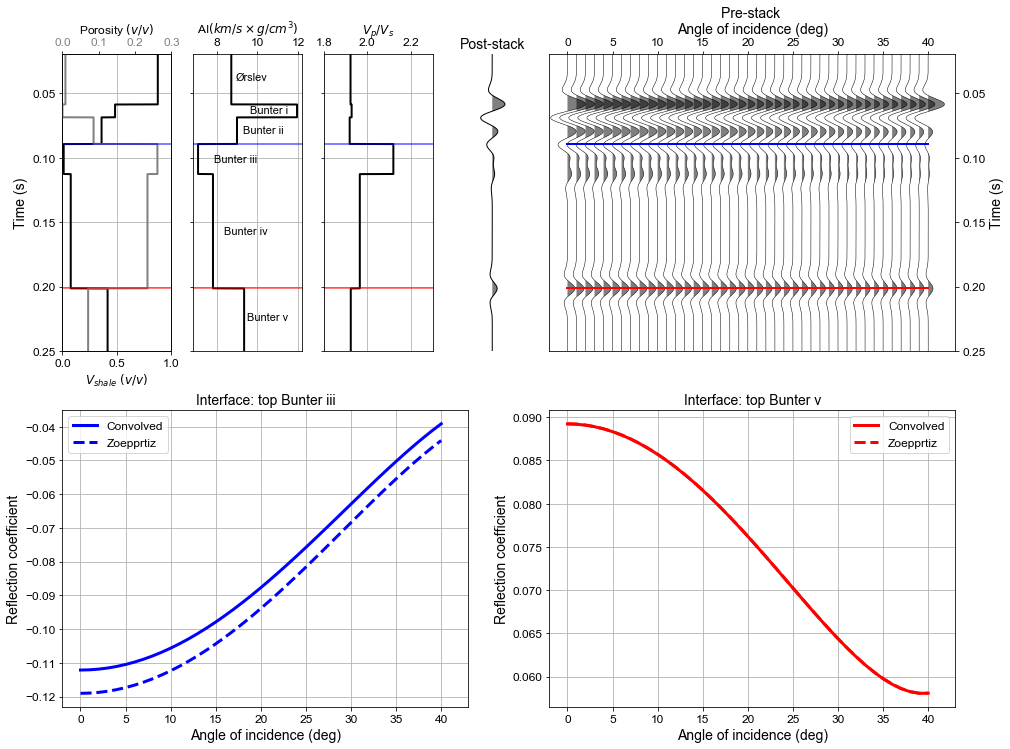

In [31]:
#############################################
#
#       PLOTTING HAPPENS BELOW HERE
#


#   Create the plot figure
fig = plt.figure(figsize=(16, 12))
fig.set_facecolor('white')


#   Plot log curves in two-way time
ax0a = fig.add_subplot(2,7,1)
l_lit_dig, = ax0a.plot(lit_dig, t, 'k', lw=2)
ax0a.set_ylim((min_plot_time,max_plot_time))
ax0a.set_xlim(0, 1.0)
ax0a.invert_yaxis()
ax0a.set_ylabel('Time (s)', fontsize = 14)
ax0a.xaxis.tick_bottom()
ax0a.xaxis.set_label_position('bottom')
ax0a.set_xlabel(r'$V_{shale} \ (v/v)$', fontsize = 12)
ax0a.grid()

cl = 'grey'
ax0a2 = ax0a.twiny()  # instantiate a second axes that shares the same y-axis
l_phi_dig = ax0a2.plot(phi_dig, t, color=cl,lw=2)
ax0a2.tick_params(axis='x', labelcolor=cl)
ax0a2.set_xlabel('Porosity ' + r'$(v/v)$', fontsize = 12)
ax0a2.set_xlim(0,0.3)
ax0a2.axhline(lyr_times[0,2], color='blue', lw=2, alpha=0.5)
ax0a2.axhline(lyr_times[0,4], color='red', lw=2, alpha=0.5)

ax0b = fig.add_subplot(272)
l_ai_dig, = ax0b.plot((vp_dig/1000)*rho_dig, t, 'k', lw=2)
ax0b.set_ylim((min_plot_time,max_plot_time))
ax0b.invert_yaxis()
ax0b.xaxis.tick_top()
ax0b.xaxis.set_label_position('top')
ax0b.set_xlabel('AI' + r'$(km/s \times g/cm^3)$', fontsize = 12)
ax0b.set_yticklabels('')
ax0b.axhline(lyr_times[0,2], color='blue', lw=2, alpha=0.5)
ax0b.axhline(lyr_times[0,4], color='red', lw=2, alpha=0.5)
ax0b.grid()

plt.text(10.5,
        min_plot_time + (lyr_times[0,0] - min_plot_time)/2.,
        'Ørslev',
        fontsize=11,
        horizontalalignment='right')
plt.text(11.5,
        lyr_times[0,1] + (lyr_times[0,0] - lyr_times[0,1])/2. + 0.002,
        'Bunter i',
        fontsize=11,
        horizontalalignment='right')
plt.text(11.3,
        lyr_times[0,2] + (lyr_times[0,1] - lyr_times[0,2])/2. + 0.002,
        'Bunter ii',
        fontsize=11,
        horizontalalignment='right')
plt.text(10,
        lyr_times[0,3] + (lyr_times[0,2] - lyr_times[0,3])/2. + 0.002,
        'Bunter iii',
        fontsize=11,
        horizontalalignment='right')
plt.text(10.5,
        lyr_times[0,4] + (lyr_times[0,3] - lyr_times[0,4])/2. + 0.002,
        'Bunter iv',
        fontsize=11,
        horizontalalignment='right')
plt.text(11.5,
        lyr_times[0,4] + (max_plot_time - lyr_times[0,4])/2.,
        'Bunter v',
        fontsize=11,
        horizontalalignment='right')

ax0c = fig.add_subplot(273)
l_ps_dig, = ax0c.plot(vp_dig/vs_dig, t, 'k', lw=2)
ax0c.set_ylim((min_plot_time,max_plot_time))
ax0c.invert_yaxis()
ax0c.xaxis.tick_top()
ax0c.xaxis.set_label_position('top')
ax0c.set_xlabel(r'$V_p/V_s$', fontsize = 12)
ax0c.set_xlim([1.8,2.3])
ax0c.set_yticklabels('')
ax0c.axhline(lyr_times[0,2], color='blue', lw=2, alpha=0.5)
ax0c.axhline(lyr_times[0,4], color='red', lw=2, alpha=0.5)
ax0c.grid()

# Plot post-stack trace
ax1 = fig.add_subplot(2,28,14)
pst = syn_zoep_pp.T.sum(axis=1) # Stacked trace
ax1.plot(pst,t,'k',lw=1)
ax1.fill_betweenx(t, pst, 0, pst>0, facecolor='k', linewidth=0,alpha=0.5)
#ax1.fill_betweenx(t, pst, 0, pst<0, facecolor=[0.6,0.6,1.0], linewidth=0)
ax1.set_ylim((min_plot_time,max_plot_time))
ax1.invert_yaxis()
ax1.set_axis_off()
ax1.set_title('Post-stack', fontsize=14)

# Plot pre-stack traces
ax2 = fig.add_subplot(222)
plot_vawig(ax2, syn_zoep_pp, t, excursion)
ax2.set_ylim((min_plot_time,max_plot_time))
l_int3 = ax2.plot(lyr_times[:,2], color='blue', lw=2)
l_int5 = ax2.plot(lyr_times[:,4], color='red', lw=2)
ax2.invert_yaxis()
#label_str = 'Synthetic angle gather\nLayer 2 thickness = %4.1fm' % thickness
ax2.set_xlabel('Pre-stack \nAngle of incidence (deg)', fontsize = 14)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Time (s)', fontsize = 14)

#   Plot Zoeppritz and convolved reflectivity curves    
ax3 = fig.add_subplot(2,2,3)

l_syn1, = ax3.plot(line3, color='blue', linewidth=3)
l_rc1, = ax3.plot( rc_zoep_pp[:,2], '--', color='blue', lw=3)

ax3.set_xlim((-excursion, ntrc+excursion))
ax3.grid()
ax3.set_xlabel('Angle of incidence (deg)', fontsize = 14)
ax3.set_ylabel('Reflection coefficient', fontsize = 14)
ax3.set_title('Interface: top Bunter iii', fontsize = 14)
plt.legend([l_syn1, l_rc1], ['Convolved', 'Zoepprtiz'], loc=0)

ax4 = fig.add_subplot(2,2,4)
l_syn2, = ax4.plot(line5, color='red', linewidth=3)
l_rc2, = ax4.plot( rc_zoep_pp[:,4], '--', color='red', lw=3)
ax4.set_xlim((-excursion, ntrc+excursion))
ax4.grid()
ax4.set_xlabel('Angle of incidence (deg)', fontsize = 14)
ax4.set_ylabel('Reflection coefficient', fontsize = 14)
ax4.set_title('Interface: top Bunter v', fontsize = 14)
plt.legend([l_syn2, l_rc2], ['Convolved', 'Zoepprtiz'], loc=0)

#   Save the plot
#plt.savefig('blocky_AVO.png',dpi = 400)

#   Display the plot
plt.show()

# Fig caption

To investigate the seismic characteristics of the Bunter Formation, we perform a blocky AVO modeling approach. Figure x(a-c) shows the average P and S-velocities and density for the various formations within our target interval. Figure x(d) shows the corresponding post-stack trace generated from the pre-stack traces in Figure x(e). Zoeppritz equations are used to calculate the reflection coefficients, which are then convolved with a 30 Hz Ricker wavelet. Figure x(f) and x(g) show the reflection coefficients as function of incidence angle for two interfaces: Top Bunter iii and Top Bunter v, respectively. Both the Zoeppritz and convolved reflection coefficients are shown to investigate possible tuning effects, which are insignificant for both of these interfaces.

Comparing the post-stack trace in Figure x(d) with a seismic subsection extending beyond the Løve-1 position, we see that we have managed to reproduce the key seismic reflection events, although we also observe that there are some discripnanies in the amplitude strengths and positioning. This simplified approach is of course unable to exactly reproduce the seismic character from field data which is influenced by coherent and random noise, acquisition configurations and data processing. However, we still manage to itentify the key events for the targeted Bunter Formation, which are consistent with the contrasts in acoustic impedance and Vp/Vs measurements from Løve-1. The two most powerful amplitude signals are the two first arriving events: a red peak followed by a blue trought; representing the Ørslev-to-Bunter (i) and Bunter (i)-to-Bunter (ii) interfaces, respectively. The top Bunter iii interface is characterized by a reatively weak trough, and this is consistent with what we see in the seismic section in Figure y, where a relatively weak and partly discontinous event can be identified. Because the top Bunter iii event is not easily interpretable and is more prone to tuning effects, we rather focus on the base Bunter iv interface for amplitude analysis, i.e. the Bunter (iv)-to-Bunter (v) transition. In addition, we observe that there is a red peak event beneath the top Bunter ii reflection, which is a product of constructive interfering wavelet sidelobes from the top interfaces of Bunter ii and iii. This is event is also identified in the seismic section in Figure y.

Next, we introduce the calibrated rock physics model to calculate a some different reservoir scenarios for the Bunter Formation (Dvorkin et al., 2014). We adjust the porosity and shale volume logs to simulate other possible geological properties, and then use these as input to our rock physics model to calculate the corresponding P and S-velocities and densities.

...



(Acknowledgements: We thank the open-source community at SEG wiki tutorials for sharing the python scripts, which we have used and customized for our research.)


# Rock physics modelling

In [12]:
def hertzmindlin(K0, G0, phi, phic=0.4, Cn=8.6, P=10, f=1):
    '''
    Hertz-Mindlin model
    written by aadm (2015) from Rock Physics Handbook, p.246

    INPUT
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    phic: critical porosity (default 0.4)
    Cn: coordination nnumber (default 8.6)
    P: confining pressure in MPa (default 10)
    f: shear modulus correction factor
       1=dry pack with perfect adhesion
       0=dry frictionless pack
    '''
    P   /= 1e3 # converts pressure in same units as solid moduli (GPa)
    PR0  =(3*K0-2*G0)/(6*K0+2*G0) # poisson's ratio of mineral mixture
    K_HM = (P*(Cn**2*(1-phic)**2*G0**2) / (18*np.pi**2*(1-PR0)**2))**(1/3)
    G_HM = ((2+3*f-PR0*(1+3*f))/(5*(2-PR0))) * ((P*(3*Cn**2*(1-phic)**2*G0**2)/(2*np.pi**2*(1-PR0)**2)))**(1/3)
    return K_HM, G_HM

In [22]:
k, g = hertzmindlin(37, 44, 0.1, phic=0.4, Cn=8.6, P=40, f=1)
print(k, g)

2.3835121152112975 3.492623782892534


In [17]:
phi

array([0.        , 0.0040404 , 0.00808081, 0.01212121, 0.01616162,
       0.02020202, 0.02424242, 0.02828283, 0.03232323, 0.03636364,
       0.04040404, 0.04444444, 0.04848485, 0.05252525, 0.05656566,
       0.06060606, 0.06464646, 0.06868687, 0.07272727, 0.07676768,
       0.08080808, 0.08484848, 0.08888889, 0.09292929, 0.0969697 ,
       0.1010101 , 0.10505051, 0.10909091, 0.11313131, 0.11717172,
       0.12121212, 0.12525253, 0.12929293, 0.13333333, 0.13737374,
       0.14141414, 0.14545455, 0.14949495, 0.15353535, 0.15757576,
       0.16161616, 0.16565657, 0.16969697, 0.17373737, 0.17777778,
       0.18181818, 0.18585859, 0.18989899, 0.19393939, 0.1979798 ,
       0.2020202 , 0.20606061, 0.21010101, 0.21414141, 0.21818182,
       0.22222222, 0.22626263, 0.23030303, 0.23434343, 0.23838384,
       0.24242424, 0.24646465, 0.25050505, 0.25454545, 0.25858586,
       0.26262626, 0.26666667, 0.27070707, 0.27474747, 0.27878788,
       0.28282828, 0.28686869, 0.29090909, 0.29494949, 0.29898